In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr

%matplotlib inline

In [2]:
sc.settings.verbosity = 3 
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.2 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
results_file = 'write/230212_Mus_QC_R1.h5ad'

In [4]:
adata = sc.read_10x_mtx(
    '/mnt/d/Sambe/Mouse_Testis_SC/data/filtered_feature_bc_matrix_1/',  
    var_names='gene_symbols', 
    cache=True)           

... reading from cache file cache/mnt-d-Sambe-Mouse_Testis_SC-data-filtered_feature_bc_matrix_1-matrix.h5ad


In [5]:
adata

AnnData object with n_obs × n_vars = 2552 × 51868
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


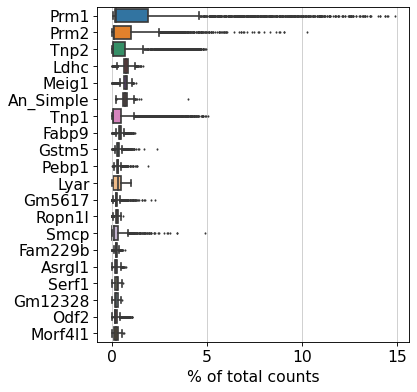

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') 

In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [9]:
adata

AnnData object with n_obs × n_vars = 2552 × 51868
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

... storing 'feature_types' as categorical


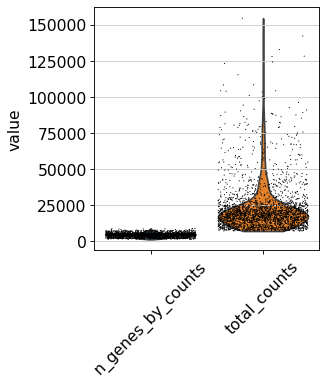

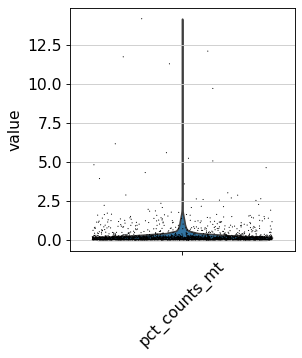

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, rotation= 45)
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, rotation= 45)

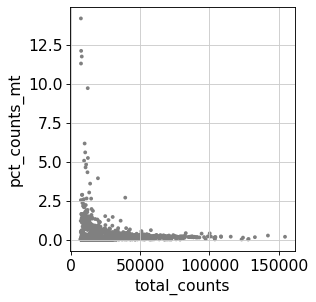

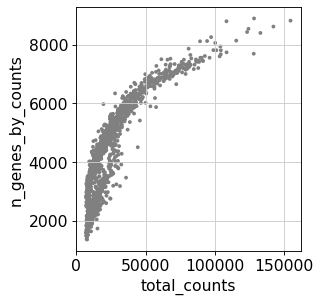

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGCTTATCG-1,4977,23114.0,8.0,0.034611
AAACCTGGTTGAGTTC-1,4694,19002.0,8.0,0.042101
AAACCTGTCAACGAAA-1,4908,22849.0,1.0,0.004377
AAACGGGCACAGGTTT-1,5392,27921.0,4.0,0.014326
AAACGGGTCATTTGGG-1,4718,18466.0,4.0,0.021661
...,...,...,...,...
TTTGGTTTCTACTATC-2,4196,14006.0,8.0,0.057118
TTTGTCACATCGGTTA-2,4960,23094.0,5.0,0.021651
TTTGTCAGTCCAGTTA-2,1856,7613.0,1.0,0.013135
TTTGTCATCTGTCCGT-2,4868,20155.0,79.0,0.391962


In [13]:
adata = adata[adata.obs['pct_counts_mt'] < 10, :]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 2548 × 51868
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, copying.
filtered out 28559 genes that are detected in less than 3 cells


In [16]:
adata

AnnData object with n_obs × n_vars = 2548 × 23309
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

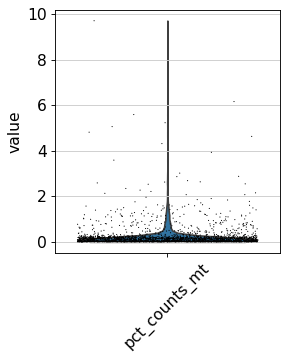

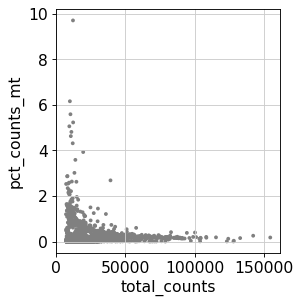

In [17]:
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, rotation= 45)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

In [18]:
adata.raw = adata

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 61.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.5%
Elapsed time: 2.5 seconds


24

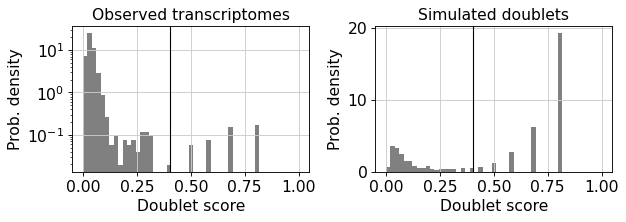

In [20]:
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [21]:
adata

AnnData object with n_obs × n_vars = 2548 × 23309
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'

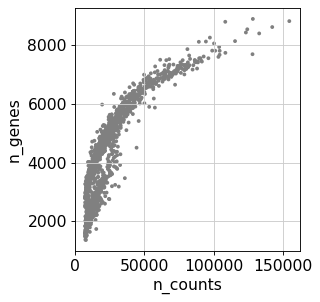

In [22]:
sc.pl.scatter(adata, x = 'n_counts', y = 'n_genes')

In [23]:
#adata = adata[adata.obs['n_genes'] < 7500, :]

In [24]:
#adata

In [25]:
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


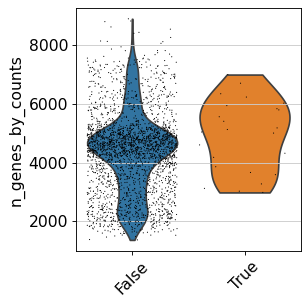

In [26]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [27]:
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(2524, 23309)


In [28]:
adata.write(results_file)